# Work on the OCSEAN DATA for lingpy modelling

This is incomplete, but contains some very important functionality to find issues with the data with a **check** function to search all languages for symbols or word segments.

At present, it assumes you will rerun "process_linguistic_excel_data.ipynb" if you make modifications to the raw data. This should be streamlined.

In [420]:
import pandas as pd
from lingpy import * # We're just importing everything from lingpy for simplicity
from lingpy.sequence.sound_classes import ipa2tokens
import re
import os
import math

## Metadata

We created a list of "good" languages in process_linguistic_excel_data.ipynb, which we can treat as the main reference to link languages to files.

In [421]:
metadata=pd.read_excel("OCSEAN_initial_englishsheet.xlsx")  
metadata.index=metadata['Language_AsInFile']
metadata.head()

,Unnamed: 0,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,...,"(111, 'QCFileUpdated')","(112, 'QCFileUpdated')","(113, 'QCFileUpdated')","(117, 'QCFileUpdated')","(120, 'QCFileUpdated')",fullfile,Has_IPA,Has_English,Keep,Language_AsInFile
Language_AsInFile,,,,,,,,,,,,,,,,,,,,,
Abui_Bunggeta,0,Abui Bunggeta,ABZ,Indonesia,604,Yes,Yes,Some English and or Indonesian words in this l...,", and ; and ~ (?). Only used , and ;",41,...,True,True,True,True,True,CleanedFiles/OCSEAN-ABZ_20240605-BUNGGETA_WORD...,True,True,True,Abui_Bunggeta
Abui_Kilakawada,1,Abui Kilakawada,ABZ,Indonesia,604,Yes,Yes,English and English Elicitation notes complete...,", and ; and ~ (?). Only used , and ;",41,...,True,True,True,True,True,CleanedFiles/OCSEAN-ABZ_20240606-KILAKAWADA_WO...,False,True,True,Abui_Kilakawada
Abui_Mobyetang,2,Abui Mobyetang,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,...,True,True,True,True,True,CleanedFiles/OCSEAN-ABZ_20240610-MOBYETANG_WOR...,False,True,True,Abui_Mobyetang
Abui_Pelman,3,Abui Pelman,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,...,True,True,True,True,True,CleanedFiles/OCSEAN-ABZ_20240610-PELMAN_WORDLI...,False,True,True,Abui_Pelman
Agusan_Manobo,10,Agusan Manobo,MSM,the Phillipines,1225,Yes,Yes,Tagalog and English present and both match the...,",",FALSE,...,True,True,True,True,True,CleanedFiles/OCSEAN-MSM_20240517-WORDLIST_1to1...,False,True,True,Agusan_Manobo


### Using the metadata:

We cal lookup the file associated with 'Balinese' with the following code. Its in the "CleanedFiles" folder.

In [422]:
print(metadata.loc['Balinese','QC_FileName'])
print(metadata.loc['Ata',:])

OCSEAN-BAN_20220714-WORDLIST_PostQC.xlsx
Unnamed: 0                                                                          17
Language_BasedOnMasterSheet                                                        Ata
ISO code (from Original_FileName)                                                  ATM
COUNTRY                                                                the Phillipines
LocalWordsPresent                                                                  938
                                                           ...                        
fullfile                             CleanedFiles-v1.1/edited-OCSEAN-ATM_20240323-W...
Has_IPA                                                                          False
Has_English                                                                       True
Keep                                                                              True
Language_AsInFile                                                                  Ata
Na

## Reading our data

We can read in our data very simply, as its been processed into a simple dataset of 'concept','form' and 'doculect'. (There is an ID column too, just a number to identify each row).

In [423]:
od = pd.read_table('OCSEAN_initial_joineddata.tsv')
od=od[['ID','concept','form','doculect']]
od=od.dropna()
od.shape

(70472, 4)

Its very important to be able to search for "bad characters" that cannot be converted to IPA and might indicate problems for manual examination. These functions do that, and we have examples of their use below. Don't worry too much about how they work just yet.

First we define a list of "bad symbols" for later use, then define the functions.

In [424]:
badsymbols=['(',')', # Brackets
            ' ','\t', # Spaces
            'ė', 'ό', 'ǹ', 'ѐ', # Accented symbols
            '\'','’','´', # quotes used as glottels
            '–','-','=', # separator symbols? NB these are technically different!
            '\\','?','…' # others!
           ]

In [425]:
def checkpair(od,symbol, language,reportok=False,show=False,what='form',regex=False):
    # Check a single symbol/language pair
    tlang=od[od['doculect']==language]
    test=tlang[what].str.contains(symbol, regex=regex)
    total=0
    if (any(test)):
        total += test.sum()
        print(language,"contains",total, 
                      "of the",symbol,"symbol")
        if show:
            showforms=[b for a, b in zip(test,tlang.index) if a]
            for x in showforms:
                print("...",tlang['form'].loc[x]," - concept:", tlang['concept'].loc[x])
    elif reportok:
        print(language, "OK!")
    return(total)
    
def check(od, symbols=badsymbols, languages="all", reportok=False,show=False,what='form',regex=False):
    ## Check for all specified symbols in all requested languages
    if languages == "all":
        languages = list(od['doculect'].unique())
    totals = {}
    for symbol in symbols:
        totals[symbol] = {}
        for language in languages:
            totals[symbol][language] = checkpair(od,symbol,language,reportok,show,what,regex)
    return totals

However, this data still contain forms separated by a comma, which need to be put into separate rows. Here is an example where we search for the comma with the simpler of the two functions:

In [426]:
totals=checkpair(od,',','Agutaynen',show=True)

Agutaynen contains 4 of the , symbol
... laod, kadadaliman  - concept: ocean
... yo,  - concept: 1sg
... ,rlt34jtprekhjrtuhktmhgj7trh  - concept: sea cucumber
... pantay, kapatagan  - concept: path, trail


In [427]:
od.loc[(od['doculect']=='Agutaynen') & (od['concept']=='ocean'),:]

,ID,concept,form,doculect
4273,4273,ocean,"laod, kadadaliman",Agutaynen


And here is an example using the more complicated function, which accepts lists as input to check multiple languages and/or symbols.

In [428]:
totals=check(od,symbols=['(v)'],show=True)

In [429]:
total=check(od,symbols=['NOUN'],what='concept',show=True)

In [430]:
total=check(od,symbols=[r'\(\w+\)'],regex=True,show=True)

In [431]:
total=check(od,symbols=[r'\b[A-Z]'],regex=True)

Abui_Bunggeta contains 74 of the \b[A-Z] symbol
Abui_Kilakawada contains 1 of the \b[A-Z] symbol
Abui_Mobyetang contains 1 of the \b[A-Z] symbol
Abui_Pelman contains 3 of the \b[A-Z] symbol
Akeanon contains 205 of the \b[A-Z] symbol
Boholano contains 2 of the \b[A-Z] symbol
Bontoc contains 1 of the \b[A-Z] symbol
Bulus contains 7 of the \b[A-Z] symbol
Enggano contains 1 of the \b[A-Z] symbol
Hanunuo contains 1 of the \b[A-Z] symbol
Hattang_Kaye contains 4 of the \b[A-Z] symbol
Hiligaynon contains 1 of the \b[A-Z] symbol
Ilognon contains 3 of the \b[A-Z] symbol
Ilokano contains 1 of the \b[A-Z] symbol
Inabaknon contains 1 of the \b[A-Z] symbol
Ivatan_Isabtangen contains 9 of the \b[A-Z] symbol
Ivatan_Ichbayatan contains 5 of the \b[A-Z] symbol
Kamayo contains 1 of the \b[A-Z] symbol
Kapampangan contains 2 of the \b[A-Z] symbol
Kolibogon contains 1 of the \b[A-Z] symbol
Kusa contains 1 of the \b[A-Z] symbol
Manea contains 1 of the \b[A-Z] symbol
Meranaw contains 3 of the \b[A-Z] symbol
M

In [432]:
#totals=check(od,symbols=['don'],show=True,what='concept')

In [433]:
totals=check(od,symbols=['~'],show=True)

In [434]:
totals=check(od,symbols=[';'],show=True)

Arta contains 14 of the ; symbol
... tabug; tubog  - concept: mud
... mepipiyaya; kamahalan  - concept: volcano
... laab; bituwa; laab na bituwa  - concept: cave
... linung-ab; dikalabitu  - concept: ocean
... inang; mele-mang  - concept: rough
... melinas; tagmuk  - concept: lake
... tinatahan bukid; talon bukid  - concept: forest
... tupra langiti; uduna langiti  - concept: sunbeams
... diklemi; medigsen; kumen  - concept: monsoon wind
... pinamunod; hetud  - concept: hail
... kadasweng; bawot  - concept: maggots
... sabilikul; sabili  - concept: shoulder
... limaku; ay limakuy  - concept: hand
... awan; wala  - concept: horn, trumpet
Balangao contains 1 of the ; symbol
... ha;chuwen  - concept: pour
Boholano contains 1 of the ; symbol
... Bangil; kalso  - concept: wind
Bolinao contains 1 of the ; symbol
... rwan pulo tan a;pat  - concept: twenty four
Ilognon contains 1 of the ; symbol
... duta; yuta  - concept: land, earth, soil
Kankana_ey contains 3 of the ; symbol
... posos; bigti

In [435]:
tlang=od
test=tlang['form'].str.contains('|', regex=False)
any(test)
#check(od,symbols=['&'],show=True)

False

Splitting on a ";" requires a bit more care to be sure - it looks like these might be used as meaningful sounds and should be re-examined?

However, this is how we split on , and ; using the 'explode' function which duplicates rows when there is a list as an entry.

In [436]:
od['form']=od['form'].str.split(',') # replace strings with , with a list of values
od=od.explode('form') # duplicate rows
od['form']=od['form'].str.split(';') # Same for ;
od=od.explode('form') 
od=od.dropna() # Remove anything that has become missing or invalid
od['ID']=range(od.shape[0]) # Give the new index
od.index=od['ID']
print(od.head(15))
print(od.shape)

    ID    concept              form       doculect
ID                                                
0    0        sun             wariy  Abui_Bunggeta
1    1       moon              'uya  Abui_Bunggeta
2    2       star             furiy  Abui_Bunggeta
3    3        sky            'adiiy  Abui_Bunggeta
4    4      earth              buku  Abui_Bunggeta
5    5      earth             bukuw  Abui_Bunggeta
6    6      cloud            taboqi  Abui_Bunggeta
7    7       wind            simooi  Abui_Bunggeta
8    8       wind             smooi  Abui_Bunggeta
9    9       rain             anuui  Abui_Bunggeta
10  10    drizzle  anuui wobiyaanra  Abui_Bunggeta
11  11    drizzle   anuui wobiyaana  Abui_Bunggeta
12  12    drizzle      anuui paawal  Abui_Bunggeta
13  13        dew               moo  Abui_Bunggeta
14  14  mist, fog            taboqi  Abui_Bunggeta
(70565, 4)


## Working towards IPA

We need our symbols to be readable by **lingpy**, and to use a comparable way of encoding meaningful phonetic variation to "tokens", i.e. fundamental sounds.

Any string can be coerced to IPA using `ipa2tokens` assuming that it doesn't contain symbols forbidden in IPA. To convert a string such as "wobiyaanra" to such tokens we can call `ipa2tokens`. But this returns the tokens as a list, not as a string, so we've made a function to do this for every string in a list, and return a list.

This is a test, because it will fail on forbidden symbols. (Try introducing a space into the example...)

In [437]:
def ipa2tokens_list(d):
    ## Takes a list of dataframe column
    ## Apply transformation to words that are present, and collapse that back to a string
    ret = [''.join(ipa2tokens(x)) for x in d]
    return ret

In [438]:
ipa2tokens("anuui.wobiyaana") # Takes only a string, returns a list

['a', 'n', 'uui', 'w', 'o', 'b', 'iyaa', 'n', 'a']

In [439]:
ipa2tokens_list(["anuui.wobiyaana","simooi"]) # takes a list, returns a list

['anuuiwobiyaana', 'simooi']

In [440]:
ipa2tokens("ka-yog")

['k', 'a', 'yo', 'g']

In [441]:
ipa2tokens("kayog")

['k', 'ayo', 'g']

In [442]:
ipa2tokens("ka.yog")

['k', 'a', 'yo', 'g']

In [443]:
od.loc[4270:4275,:] # This was once a split 'Agutaynen' 'ocean'

,ID,concept,form,doculect
ID,,,,
4270,4270,cave,bulwat kuweba,Agutaynen
4271,4271,water,we,Agutaynen
4272,4272,sea,talce,Agutaynen
4273,4273,ocean,laod,Agutaynen
4274,4274,ocean,kadadaliman,Agutaynen
4275,4275,rough,magaspang,Agutaynen


# Some testing

We will use the check function on different symbols. These should be manually fixed, unless an automatic rule is safe and appropriate. 

In [444]:
## This is how I got the "ė" symbol
od.loc[(od['doculect']=='Enggano') & (od['concept']=='dog'),:]

,ID,concept,form,doculect
ID,,,,
25688,25688,dog,bė,Enggano


In [445]:
test=check(od,what="concept",symbols=['firstbornchild'],show=True)

Akeanon contains 2 of the firstbornchild symbol
... Panganay  - concept: firstbornchild
... kamug-eangan  - concept: firstbornchild
Ati contains 1 of the firstbornchild symbol
... subang  - concept: firstbornchild
Kinaray_a contains 1 of the firstbornchild symbol
... panganay  - concept: firstbornchild
Tausug contains 1 of the firstbornchild symbol
... kakah  - concept: firstbornchild


In [446]:
totals=check(od,symbols=['ẽ'])
totals=check(od,symbols=['á']) # Not present
totals=check(od,symbols=['à'])
totals=check(od,symbols=['ė'])
totals=check(od,symbols=['ǹ'])
totals=check(od,symbols=['ň'])

Balinese contains 107 of the ẽ symbol
Agusan_Manobo contains 5 of the à symbol
Tboli contains 21 of the à symbol
Enggano contains 23 of the ė symbol
Ivatan_Ichbayatan contains 40 of the ǹ symbol
Ivatan_Isabtangen contains 26 of the ň symbol


In [447]:
totals=check(od,languages=['Agusan_Manobo'], symbols=['à'],show=True)

Agusan_Manobo contains 5 of the à symbol
... nanà  - concept: pus
... lagà  - concept: boil
... kalà  - concept: frying pan
... pinatà  - concept: bamboo water container
... batà te manok  - concept: egg


We have identified that 'ngh' needs treating carefully to separate out 'ng.h' from 'n.gh'. Both 'ng' and 'gh' might then be needing an IPA symbol.

In [448]:
totals=check(od,symbols=['ngh'],show=True)

Abui_Mobyetang contains 1 of the ngh symbol
... minghede  - concept: surrender
Agusan_Manobo contains 4 of the ngh symbol
... ugpanghihingutohay  - concept: delouse, remove lice
... dalanghita  - concept: citrus
... ma'anghang  - concept: spicy
... estranghero  - concept: stranger
Akeanon contains 10 of the ngh symbol
... kamanghuran  - concept: youngest child
... Manghod  - concept: brother
... Manghod  - concept: sister
... Manghod nga eaki  - concept: youngerbrother
... Manghod nga bayi  - concept: younger sister
... manghod  - concept: youngersibling
... balinghoy  - concept: cassava
... anghit  - concept: smell
... panghi  - concept: smell
... Estranghero  - concept: stranger
Arta contains 2 of the ngh symbol
... buwanghina  - concept: rough bamboo, giant bambooo (dendrocalamus asper)
... manghuras  - concept: wash
Ati contains 1 of the ngh symbol
... panghabok habok kay mata  - concept: conjunctivitis
Balangao contains 9 of the ngh symbol
... apenghan  - concept: cousin
... apeng

In [449]:
totals=check(od,symbols=['gh'],languages=["Waray"],show=True)

Waray contains 11 of the gh symbol
... dughan  - concept: chest
... pakighilawas  - concept: sexual intercourse, copulate
... koghad  - concept: phlegm
... naghagong  - concept: snore
... paghigop  - concept: sip, slurp
... paghukay  - concept: dig
... dalanghita  - concept: citrus
... balinghoy  - concept: cassava
... daghan  - concept: many
... estranghero  - concept: stranger
... pakighilawas  - concept: adultery


In [452]:
totals=check(od,symbols=['('],show=True)

Abui_Bunggeta contains 1 of the ( symbol
... tataang (tataang buku  - concept: lower arm
Agusan_Manobo contains 2 of the ( symbol
... sognowanan (for smoking)  - concept: rack (for storing food)
... adiya to (yain lugar)  - concept: transfer (another location)
Akeanon contains 2 of the ( symbol
... Kabugwason (morning star)  - concept: venus
... Asawa (nga eaki)  - concept: husband
Balangao contains 1 of the ( symbol
... fegfikat (ag-akaw)  - concept: day
Bali_Aga contains 2 of the ( symbol
... maman (lebih muda dr ibubapak)  - concept: uncle
... wak (lebih tua dari ibubapak)  - concept: mother's brother
Manubo_Tasaday contains 1 of the ( symbol
... duma setlahadi bayi kdoo lukes di (ubus  - concept: orphan
Tagbanwa_Central contains 2 of the ( symbol
... sanggup(muslim tradition)  - concept: dowry
... talikudan (buktot in taw)  - concept: behind


# Checking everything

Here we check for every symbol in our list. It makes a very long output!

In [451]:
totals=check(od)

Abui_Bunggeta contains 1 of the ( symbol
Agusan_Manobo contains 2 of the ( symbol
Akeanon contains 2 of the ( symbol
Balangao contains 1 of the ( symbol
Bali_Aga contains 2 of the ( symbol
Manubo_Tasaday contains 1 of the ( symbol
Tagbanwa_Central contains 2 of the ( symbol
Abui_Bunggeta contains 1 of the ) symbol
Agusan_Manobo contains 2 of the ) symbol
Akeanon contains 2 of the ) symbol
Balangao contains 1 of the ) symbol
Bali_Aga contains 2 of the ) symbol
Tagbanwa_Central contains 2 of the ) symbol
Abui_Bunggeta contains 338 of the   symbol
Abui_Kilakawada contains 232 of the   symbol
Abui_Mobyetang contains 248 of the   symbol
Abui_Pelman contains 209 of the   symbol
Agusan_Manobo contains 101 of the   symbol
Agutaynen contains 135 of the   symbol
Akeanon contains 71 of the   symbol
Arta contains 185 of the   symbol
Ata contains 240 of the   symbol
Ati contains 103 of the   symbol
Ba_a contains 341 of the   symbol
Balangao contains 152 of the   symbol
Bali_Aga contains 36 of the  

## Fixing the list

Here are some options for fixing the list. Carefully check each choice and see if it is safe. If not, we need to go back to the original data and edit it.

In [262]:
total=check(od,symbols=['x'])
total=check(od,symbols=['x'],languages=['Ata','Chabacano_Caviteno','Kolibogon','Minamanwa'],show=True)

Ata contains 2 of the x symbol
Chabacano_Caviteno contains 1 of the x symbol
Ivatan_Ichbayatan contains 199 of the x symbol
Kolibogon contains 1 of the x symbol
Minamanwa contains 1 of the x symbol
Ata contains 2 of the x symbol
... polo2x  - concept: blink one's eyes
... og ohot2x  - concept: headhunting
Chabacano_Caviteno contains 1 of the x symbol
... extende  - concept: spread out
Kolibogon contains 1 of the x symbol
... taga x  - concept: has X
Minamanwa contains 1 of the x symbol
... kadang2x  - concept: cane, walking stick


In [267]:
#total=check(od,symbols=['y'],languages=['Ba_a'],show=True)
total=check(od,symbols=['ny'],languages=['Balinese'],show=True)

Balinese contains 56 of the ny symbol
... nyanyad  - concept: mud
... nyat  - concept: lowtide
... nyama muani  - concept: brother
... nyama luh  - concept: sister
... nyawan  - concept: bee
... penyu  - concept: turtle
... nyilapin  - concept: lick
... nyonyo  - concept: breast
... tutuk nyonyo  - concept: nipple, teat
... nyonyo  - concept: milk
... nyilem  - concept: drown
... kenyel  - concept: tired, weary
... punyah  - concept: drunk, intoxicated
... nyepsep  - concept: suck, breastfeed
... kinyukan  - concept: chew
... penyemeng  - concept: breakfast
... nyuwahin kutu  - concept: comb for lice with a fine tooth comb
... nyemak yẽh  - concept: fetch water
... nyejek padi  - concept: thresh
... nyiu  - concept: winnowing basket
... punyan kayu  - concept: stem, trunk
... punyan  - concept: tree
... punyan ental  - concept: lontar palm
... punyan cemara  - concept: casuarina tree
... nyuh  - concept: coconut
... nyuh  - concept: old coconut
... punyan bingin  - concept: banyan tree

In [272]:
ipa2tokens('nyupir')

['n', 'yu', 'p', 'i', 'r']

In [182]:
## Brackets - throw away everything!
od['form'] = od['form'].str.split('(').str[0]
## Symbolsipa2tokens("kayog")
od['form']=[x.replace('–','.') for x in od['form']] # long dash should be a short pause
od['form']=[x.replace('-','.') for x in od['form']] # short dash should be a short pause
od['form']=[x.replace('=','') for x in od['form']] # equals
od['form']=[x.replace(')','') for x in od['form']] # end brackets - shouldn't be here, but are
od['form']=[x.replace('\'', 'ʔ') for x in od['form']] # the ' character, glottal stop?. This is special in Python so we've "escaped" it here with a \, to match the actual character
od['form']=[x.replace('’', 'ʔ') for x in od['form']] # all the different types of quote symbol- glottal stop?
od['form']=[x.replace('´', 'ʔ') for x in od['form']] # all the different types of quote symbol- glottal stop?
od['form']=[x.replace('‘', 'ʔ') for x in od['form']] # all the different types of quote symbol- glottal stop?
od['form']=[x.replace('?', '') for x in od['form']] # question mark
od['form']=[x.replace('\\', '') for x in od['form']] # the backslash symbol. This could be encoding something like IPA?
## Phonetics
od['form']=[x.replace('ė', 'e') for x in od['form']] # Doesn't match
### od['form']=[x.replace(u"\u0113", 'ɛ') for x in od['form']] # Doesn't match
od['form']=[x.replace('ό', 'ɔ̝') for x in od['form']]
od['form']=[x.replace('ǹ', 'n̪') for x in od['form']]
od['form']=[x.replace('ѐ', 'e') for x in od['form']] # The IPA should be /e/ but that isn't single character?
od['form']=[x.replace('ň', 'ŋ') for x in od['form']] # 
od['form']=[x.replace('ng', 'ŋ') for x in od['form']] # The IPA should be /e/ but that isn't single character?
od['form']=[x.replace('x', 'h') for x in od['form']] # Correct for Ivatan, but weird in other contexts! Not many 'x' appear
# Cases, numbers, spaces
od['form']=[x.replace('…', '') for x in od['form']]
od['form']=[x.lower() for x in od['form']]
od['form']=[re.sub(r'[\d]+', '', x) for x in od['form']]
od['form']=[re.sub(r'[\s]+', '.', x) for x in od['form']]
od = od[od['form'] != '']
od = od[od['form'] != '.']
##od.loc[:,'ID']=od.index+1

In [184]:
total=check(od,symbols=['gh'],show=True)

Agusan_Manobo contains 11 of the gh symbol
... mataghum  - concept: snow
... paghindo  - concept: point at
... ughugok  - concept: snore
... ughinoktok  - concept: mourn, be in mourning
... ughimatoy  - concept: kill
... ughiŋyawon  - concept: fever
... ughihiŋyawon  - concept: cold, influenza
... ughupoŋ  - concept: swell
... aghod  - concept: broom
... daghan  - concept: many
... ug.panaghoy  - concept: whistle
Akeanon contains 3 of the gh symbol
... dughan  - concept: chest
... dighay  - concept: burp, belch
... paghigugma  - concept: love
Balangao contains 4 of the gh symbol
... ugha  - concept: Deer
... heghegʔke  - concept: Hiccough
... amgn.hegheg.ke  - concept: Thresh
... cheghen  - concept: full
Batak contains 2 of the gh symbol
... bugho  - concept: jealous
... pagtaghoy  - concept: whistle
Bicolano contains 12 of the gh symbol
... daghan  - concept: chest
... maghibarmas  - concept: shave
... maghabol  - concept: sew
... maghasok  - concept: sow
... sighin  - concept: broom


In [268]:
#total=check(od,reportok=True)

### Bug hunting

When there were bad symbols left, 'ipa2tokens_list' would give an error which was sometimes hard to debug. It was helpful to split the data into blocks of 100 and report which still failed.

You can ignore all of this now, its kept for posterity.

In [24]:
## Hunting for bad sequences that cannot be converted to IPA
## Print out the "batch number" of a block of 100 that break the algorithm
for i in range(math.floor(len(od)/100)):
    try:
        tmp=ipa2tokens_list(od['form'][(100*i):(100*i+100)])
    except:
        print(i)

In [25]:
## How we investigate a "bad" batch.
i=255
for j in range(2100*i,100*i+100):
    print(od['form'][j]) 
print(list(od['form'][(100*i):(100*i+100)]))
tmp=ipa2tokens_list(od['form'][(100*i):(100*i+100)])

['ije', 'iok', 'gua', 'be', 'iju', 'samudra', 'keyaki', 'kakih', 'jernih', 'keruh', 'pik', 'bero', 'teluk', 'pik', 'bekikeah', 'beaamuh', 'beronuwik', 'berionuwik', 'eko.bero', 'tembero', 'pusaran.air', 'bakbe', 'kumu', 'rawarawa', 'bekipuur', 'hokku', 'hutan.rimba', 'ku', 'ije', 'ijenuwik', 'dih', 'langit', 'bakkaha', 'kanua', 'kokmim', 'kokmim', 'kila', 'daoh', 'kakie', 'kakder', 'pelangi', 'kanik', 'kanik', 'kaʔpepe', 'teduh', 'bayangan', 'embun', 'udara', 'ki', 'kikaknakbe', 'awan', 'awankakeeh', 'kabut', 'be', 'bekobari', 'salju', 'es', 'be.es', 'eʔiem', 'lidah.api', 'percikan', 'kano', 'abu', 'jelaga', 'bara.api', 'uap', 'duduk.pi', 'ku.eiem', 'arang', 'kak', 'man', 'hiur', 'pa', 'kaho', 'pahiur', 'pa', 'pakimebobor', 'pakimekape', 'pamo', 'dar', 'hun', 'pahun', 'pahun', 'am', 'na', 'kaktuo', 'keturunan', 'saudara.man', 'saudara.hiur', 'aʔman', 'eahman', 'aaʔhiur', 'eah.hiur', 'eah', 'aʔ', 'kembar', 'datuk', 'nenek', 'anak.cucu', 'kuʔi']


In [26]:
# Convert to IPA
od['ipa']=ipa2tokens_list(od['form'])
od['doculect']=[re.sub(r"\s+", '_', x) for x in od['doculect']]
od['concept']=[re.sub(r"\s+", '_', x) for x in od['concept']]
od.to_csv('OCSEAN_processed_joineddata.tsv',sep='\t')

# Running pyling and models within it

We're now ready to run our data through models!

Its easy enougfh now: just read the wordlist in, run 'LexStat' to set up some basic details, and then run 'lexstat'. However that is a bit slow so we've put it in a script that can be run separately, or avoided and we just read the results.

In [27]:
ocseanwl = Wordlist('OCSEAN_processed_joineddata.tsv')

In [110]:
from tabulate import tabulate

In [113]:
print(tabulate([ocseanwl[idx] for idx in range(1, 5)]))

-  -----  ------  -------------  ------
1  moon   ʔuya    Abui_Bunggeta  ʔuya
2  star   furiy   Abui_Bunggeta  furiy
3  sky    ʔadiiy  Abui_Bunggeta  ʔadiiy
4  Earth  buku    Abui_Bunggeta  buku
-  -----  ------  -------------  ------


In [28]:
ocseanlex = LexStat(ocseanwl,check=True)

2025-05-29 21:37:50,200 [INFO] No obvious errors found in the data.


In [174]:
print(tabulate([ocseanlex[idx] for idx in range(1, 5)]))

-  -----  ------  -------------  ------  ----------------------  ------------  ----  ----  -  ------------------------------------  ---------------------  -
1  moon   ʔuya    Abui_Bunggeta  ʔuya    ['ʔ', 'uya']            [1, 7]        AX    HY    1  ['1.H.C', '1.Y.V']                    [2.0, 1.5]             0
2  star   furiy   Abui_Bunggeta  furiy   ['f', 'u', 'r', 'iy']   [3, 7, 5, 7]  AXBZ  BYRI  1  ['1.B.C', '1.Y.V', '1.R.C', '1.I.V']  [2.0, 1.5, 1.75, 0.8]  0
3  sky    ʔadiiy  Abui_Bunggeta  ʔadiiy  ['ʔ', 'a', 'd', 'iiy']  [1, 7, 1, 7]  AXBZ  HATI  1  ['1.H.C', '1.A.V', '1.T.C', '1.I.V']  [2.0, 1.5, 1.75, 0.8]  0
4  Earth  buku    Abui_Bunggeta  buku    ['b', 'u', 'k', 'u']    [1, 7, 1, 7]  AXBZ  PYKY  1  ['1.P.C', '1.Y.V', '1.K.C', '1.Y.V']  [2.0, 1.5, 1.75, 0.8]  0
-  -----  ------  -------------  ------  ----------------------  ------------  ----  ----  -  ------------------------------------  ---------------------  -


In [237]:
from lingpy.compare.sanity import average_coverage, mutual_coverage_check, synonymy 
# Check mutual coverage # Very slow for all languages
#for i in range(10, 0, -1):
#    print(i)
#    if mutual_coverage_check(ocseanlex, i):
#        print("Minimal mutual coverage is at {0} concept pairs.".format(i))
#        break
print('Avarage coverage is {0:.2f}.'.format(average_coverage(ocseanlex)))

10
9
8
7
6
5
4
3
2
1
Avarage coverage is 0.23.


In [241]:
synonyms = synonymy(ocseanlex)
# synonyms # This is just a count foe each concept

In [248]:
num_synonyms = len(ocseanlex) - len(synonyms)
syn_ratio = 1 - (len(synonyms)/len(ocseanlex))
if num_synonyms == 0:
    print('Found {0} potential synonyms.'.format(num_synonyms))
else:
    print('Found {0} potential synonyms ({1:.2}%):'.format(num_synonyms, syn_ratio*100.0))
    for (language, concept), count in sorted(synonyms.items(), key=lambda x: x[0][0]):
        if count > 10:
            print('{0:15}  {1:12}  {2}'.format(language, concept, count))

Found 5553 potential synonyms (7.9%):


This is how we can view a file. The following

Uncomment the line after to rerun cognate detection. Lots of details can be changed.



In [81]:
pycat lexstat_ocsean.py
## Note that 'pycat' is a feature of "Jupyter notebook" which is the interface we are using, not of python itself.

from lingpy import *
import os
ocseanwl = Wordlist('OCSEAN_processed_joineddata.tsv')
ocseanlex = LexStat(ocseanwl,check=True)
ocseanlex.get_scorer()
ocseanlex.cluster(method='lexstat', threshold=0.55, cluster_method='infomap', ref='cogid')
ocseanlex.output('tsv', filename=os.path.join('data','OCSEAN_processed_cognatedetected'))


In [29]:
#!python lexstat_ocsean.py &> lexstat_ocsean.log

In [246]:
lexdf=pd.read_table(os.path.join('data','OCSEAN_processed_cognatedetected.tsv'),skiprows=2,comment='#')
lexdf.head()

,ID,Unnamed: 1,ID.1,CONCEPT,FORM,DOCULECT,IPA,TOKENS,SONARS,PROSTRINGS,CLASSES,LANGID,NUMBERS,WEIGHTS,DUPLICATES,COGID
0,49686,49674,49733,(coral)_ree,fet.siaf.kenan,Mawes_Wares,fetsiafkenan,f e t s ia f k e n a n,3 7 1 3 7 3 1 7 4 7 4,AXBCYMBYBYN,BETSIBKENAN,47,47.B.C 47.E.V 47.T.C 47.S.C 47.I.V 47.B.c 47.K...,2.0 1.5 1.75 1.5 1.3 1.1 1.75 1.3 1.75 1.3 0.8,0,1
1,58,57,57,(coral)_reef,koqai,Abui_Bunggeta,koqai,k o q ai,1 7 1 7,AXBZ,KUKA,1,1.K.C 1.U.V 1.K.C 1.A.V,2.0 1.5 1.75 0.8,1,2
2,1057,1056,1056,(coral)_reef,tama.wiiy,Abui_Kilakawada,tamawiiy,t a m a w iiy,1 7 4 7 6 7,AXBYBZ,TAMAWI,2,2.T.C 2.A.V 2.M.C 2.A.V 2.W.C 2.I.V,2.0 1.5 1.75 1.3 1.75 0.8,0,3
3,1697,1696,1696,(coral)_reef,tama.kokai,Abui_Mobyetang,tamakokai,t a m a k o k ai,1 7 4 7 1 7 1 7,AXBYBYBZ,TAMAKUKA,3,3.T.C 3.A.V 3.M.C 3.A.V 3.K.C 3.U.V 3.K.C 3.A.V,2.0 1.5 1.75 1.3 1.75 1.3 1.75 0.8,0,2
4,2372,2371,2371,(coral)_reef,tama.kokai,Abui_Pelman,tamakokai,t a m a k o k ai,1 7 4 7 1 7 1 7,AXBYBYBZ,TAMAKUKA,4,4.T.C 4.A.V 4.M.C 4.A.V 4.K.C 4.U.V 4.K.C 4.A.V,2.0 1.5 1.75 1.3 1.75 1.3 1.75 0.8,0,2


In [252]:
from lingpy import Alignments
ocseanlexproc = LexStat(os.path.join('data','OCSEAN_processed_cognatedetected.tsv'),check=True)
alms = Alignments(ocseanlexproc, transcription='form', ref="cogid", segments="segments")
alms.align(method='library')

2025-06-04 10:56:46,960 [INFO] No obvious errors found in the data.


In [261]:
from lingpy import SCA
print(SCA(alms.msa['cogid'][6]))

k	a	r	a	g	t	a	n	b	u	n	b	a
k	aa	-	-	-	-	-	n	g	-	-	-	-
k	u	r	a	-	w	-	-	-	-	-	-	-
k	a	g	e	-	s	a	n	g	ee	n	-	-
c	o	r	a	-	l	-	-	-	-	-	-	-
c	o	r	a	-	l	-	-	-	-	-	-	-
k	o	r	a	-	l	-	-	-	-	-	-	-
g	aa	-	-	-	s	a	n	g	-	-	-	-
k	o	r	a	-	l	-	-	-	-	-	-	-
k	o	r	a	-	l	-	-	-	-	-	-	-
k	a	r	i	-	l	ya	n	-	-	-	-	-
k	a	r	a	-	-	-	ŋ	-	-	-	-	-
k	o	r	a	-	s	aa	n	-	-	-	-	-


In [294]:
dists = alms.get_distances(ref='cogid')
alms.output('dst', filename='OCSEAN_processed_distances')

2025-06-04 12:28:45,257 [INFO] Data has been written to file <OCSEAN_processed_distances.dst>.


In [356]:
tdists=pd.read_table('OCSEAN_processed_distances.dst',skiprows=1,header=None)
theaders = list(tdists.iloc[:,0])
dists  = pd.DataFrame(tdists.values[:,1:], columns=theaders,index=theaders)
dists = dists[dists.columns].astype(float)  # or int
dists.iloc[0:10,0:10]

,Abui_Bunggeta,Abui_Kilakawada,Abui_Mobyetang,Abui_Pelman,Agusan_Manobo,Agutaynen,Akeanon,Arta,Ata,Ati
Abui_Bunggeta,0.0000,0.2329,0.2855,0.3055,0.9589,0.9869,0.9724,0.9880,0.9786,0.9823
Abui_Kilakawada,0.2329,0.0000,0.3573,0.3806,0.9624,0.9869,0.9744,0.9980,0.9905,0.9867
Abui_Mobyetang,0.2855,0.3573,0.0000,0.2178,0.9695,0.9891,0.9862,0.9980,0.9881,0.9911
Abui_Pelman,0.3055,0.3806,0.2178,0.0000,0.9695,0.9869,0.9842,0.9960,0.9905,0.9912
Agusan_Manobo,0.9589,0.9624,0.9695,0.9695,0.0000,0.7221,0.6282,0.8260,0.6990,0.6983
Agutaynen,0.9869,0.9869,0.9891,0.9869,0.7221,0.0000,0.5665,0.7894,0.7522,0.6966
Akeanon,0.9724,0.9744,0.9862,0.9842,0.6282,0.5665,0.0000,0.7526,0.7008,0.5353
Arta,0.9880,0.9980,0.9980,0.9960,0.8260,0.7894,0.7526,0.0000,0.8376,0.8350
Ata,0.9786,0.9905,0.9881,0.9905,0.6990,0.7522,0.7008,0.8376,0.0000,0.7335
Ati,0.9823,0.9867,0.9911,0.9912,0.6983,0.6966,0.5353,0.8350,0.7335,0.0000


In [374]:
from lingpy import Tree
tree = Tree(alms.get_tree(ref='cogid', tree_calc='upgma', force=True))
print(tree.asciiArt(compact=True))nex = write_nexus(wl, mode="BEAST", filename="lieberherrkhobwa-beast.nex")

2025-06-05 13:45:03,621 [INFO] Successfully calculated tree.


          /edge.0-- /-Mawes_Wares
         |          \-Mawesdai
         |                    /edge.1-- /-Abui_Mobyetang
         |          /edge.3--|          \-Abui_Pelman
         |         |          \edge.2-- /-Abui_Bunggeta
         |         |                    \-Abui_Kilakawada
         |         |                    /-Chabacano_Caviteno
         |         |                   |                    /-Enggano
         |         |          /edge.57-|          /edge.7--|          /edge.4-- /-Bali_Aga
-root----|         |         |         |         |          \edge.6--|          \-Balinese
         |         |         |         |         |                    \edge.5-- /-Kupang_Malay
         |         |         |          \edge.56-|                              \-Loloan_Malay
         |         |         |                   |          /edge.9-- /-Manubo_Tasaday
         |         |         |                   |         |          \edge.8-- /-Obo
         |         |         |    

In [379]:
from lingpy.convert.cldf import to_cldf
to_cldf(alms, path='ocsean-cldf-new')

In [31]:
import pandas as pd
import numpy as np
from itertools import combinations

# Get unique list of languages
mylanguages = sorted(lexdf['DOCULECT'].unique())
lang_idx = {lang: i for i, lang in enumerate(languages)}

# Initialize matrix
matrix = np.zeros((len(languages), len(languages)), dtype=int)

# Group by cognate set
for cogid, group in lexdf.groupby('COGID'):
    langs = group['DOCULECT'].unique()
    for lang1, lang2 in combinations(langs, 2):
        i, j = lang_idx[lang1], lang_idx[lang2]
        matrix[i][j] += 1
        matrix[j][i] += 1  # Because it's undirected

# Optional: fill diagonal with how many unique cognate sets each language has
for lang in languages:
    matrix[lang_idx[lang]][lang_idx[lang]] = lexdf[lexdf['DOCULECT'] == lang]['COGID'].nunique()

# Turn into a pandas DataFrame
adj_df = pd.DataFrame(matrix, index=languages, columns=languages)
adj_df.head()
# Show or save
adj_df.to_csv(os.path.join('data','OCSEAN_cognate_adjacency_matrix.csv'))

In [32]:
# Assuming adj_df is a symmetric matrix
diagonal = np.diag(adj_df)
scaling_factors = np.sqrt(np.outer(diagonal, diagonal))

# Element-wise division
scaled_df = adj_df / scaling_factors

# Convert back to DataFrame with same labels
scaled_df = pd.DataFrame(scaled_df, index=adj_df.index, columns=adj_df.columns)
scaled_df.iloc[0:10,0:10]

,Abui_Bunggeta,Abui_Kilakawada,Abui_Mobyetang,Abui_Pelman,Agusan_Manobo,Agutaynen,Akeanon,Arta,Ata,Ati
Abui_Bunggeta,1.000000,0.682132,0.636361,0.613634,0.023789,0.006642,0.014900,0.006303,0.010620,0.006318
Abui_Kilakawada,0.682132,1.000000,0.632787,0.604898,0.024117,0.007375,0.015362,0.001166,0.005241,0.005261
Abui_Mobyetang,0.636361,0.632787,1.000000,0.761001,0.019523,0.006146,0.008272,0.001166,0.006551,0.003508
Abui_Pelman,0.613634,0.604898,0.761001,1.000000,0.019365,0.007315,0.009377,0.002314,0.005198,0.003479
Agusan_Manobo,0.023789,0.024117,0.019523,0.019365,1.000000,0.240245,0.302150,0.147894,0.256075,0.172000
Agutaynen,0.006642,0.007375,0.006146,0.007315,0.240245,1.000000,0.323403,0.163543,0.222020,0.173578
Akeanon,0.014900,0.015362,0.008272,0.009377,0.302150,0.323403,1.000000,0.184127,0.220994,0.283172
Arta,0.006303,0.001166,0.001166,0.002314,0.147894,0.163543,0.184127,1.000000,0.124914,0.084850
Ata,0.010620,0.005241,0.006551,0.005198,0.256075,0.222020,0.220994,0.124914,1.000000,0.141565
Ati,0.006318,0.005261,0.003508,0.003479,0.172000,0.173578,0.283172,0.084850,0.141565,1.000000


In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
adj_log = np.log10(scaled_df+0.01)
flat = adj_log.values.flatten()
scaled = StandardScaler().fit_transform(flat.reshape(-1, 1)).reshape(adj_df.shape)

# Convert back to DataFrame
adj_scaled_df = pd.DataFrame(scaled, index=adj_df.index, columns=adj_df.columns)


In [360]:
scaled_dists = dists

/Users/madjl/GoogleDrive/University/OCSEAN-2025/RESEARCH/.venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/madjl/GoogleDrive/University/OCSEAN-2025/RESEARCH/.venv/lib/python3.12/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


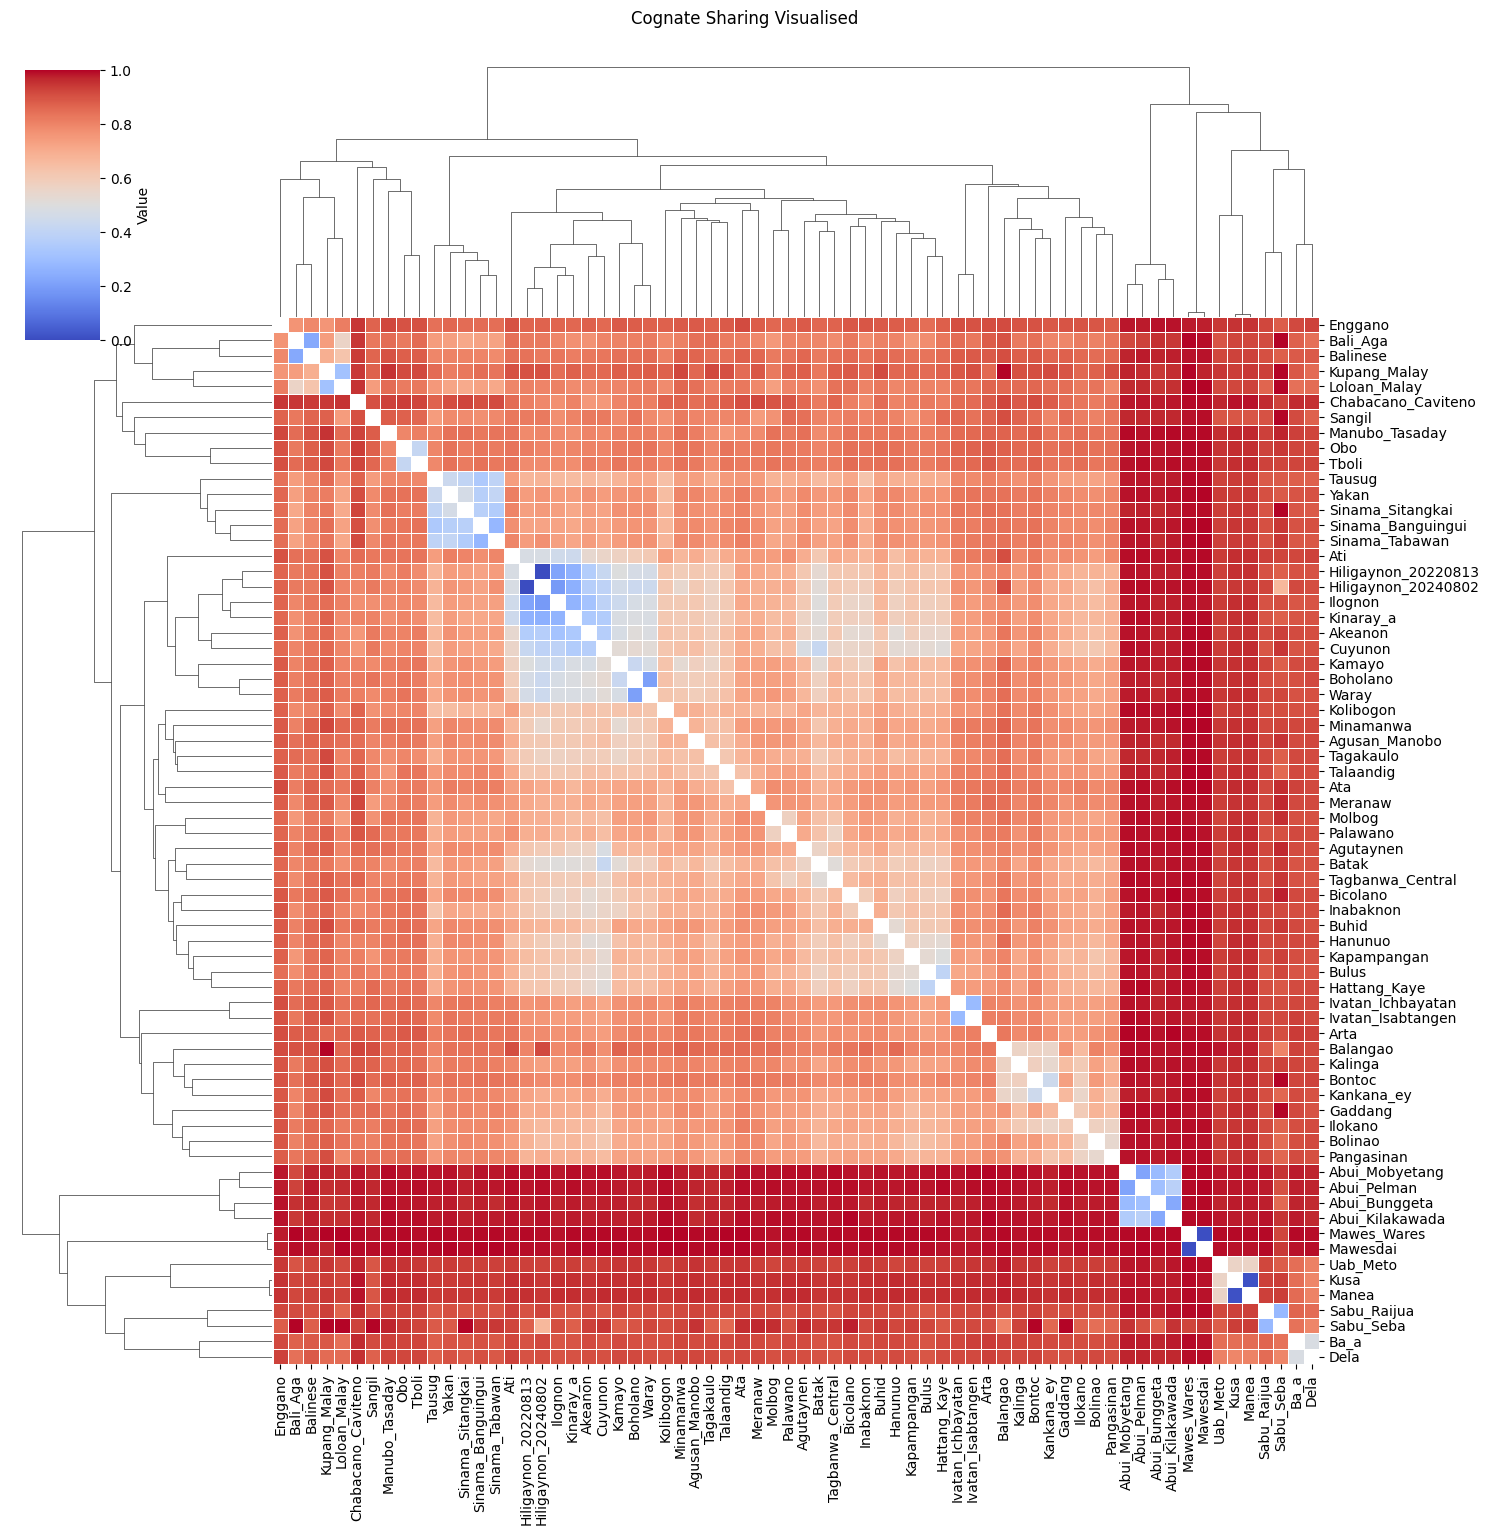

In [362]:
import seaborn as sns
import matplotlib.pyplot as plt

mask = np.eye(len(scaled_dists), dtype=bool)

# Create a clustered heatmap
sns.clustermap(
    scaled_dists,
    cmap="coolwarm",          # or any other colormap you like
    linewidths=0.5,
    mask=mask, 
    figsize=(15, 15),
    xticklabels=True,
    yticklabels=True,
    row_cluster=True,
    col_cluster=True,
    cbar_kws={'label': 'Value'},
    dendrogram_ratio=(0.2, 0.2),  # size of dendrograms
    metric="euclidean",           # distance metric for clustering
    method="average"              # linkage method
)

plt.suptitle("Cognate Sharing Visualised", y=1.02)
plt.savefig('CognateSharingHeatmap.png')
plt.show()

In [363]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [364]:
# Remove the index/column labels for PCA
X = scaled_dists.values

# Standardize the data
X_scaled = StandardScaler().fit_transform(X)

In [365]:
ncomp=15
pca = PCA(n_components=ncomp)
components = pca.fit_transform(X_scaled)
# Explained variance ratios
explained_variance = pca.explained_variance_ratio_

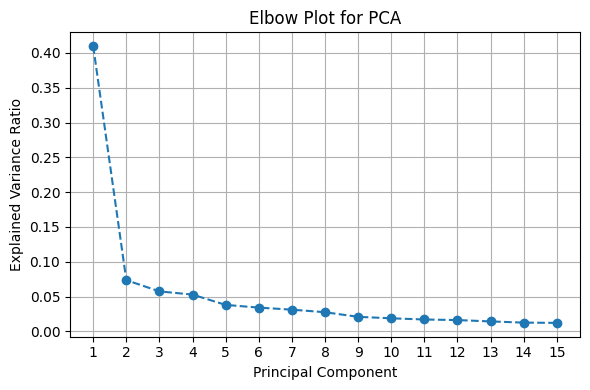

In [366]:
plt.figure(figsize=(6, 4))
plt.plot(range(1, ncomp+1), explained_variance, marker='o', linestyle='--')
plt.xticks(range(1, ncomp+1))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Elbow Plot for PCA')
plt.grid(True)
plt.tight_layout()
plt.show()

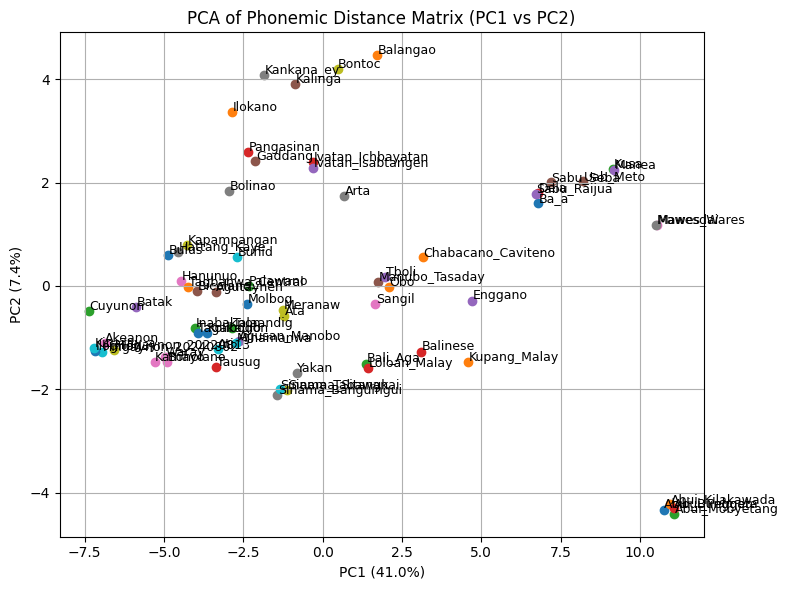

In [368]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot only the first two PCs
for i, lang in enumerate(adj_df.index):
    x, y = components[i, 0], components[i, 2]
    plt.scatter(x, y, label=lang)
    plt.text(x + 0.02, y + 0.02, lang, fontsize=9)

plt.title("PCA of Phonemic Distance Matrix (PC1 vs PC2)")
plt.xlabel("PC1 ({:.1f}%)".format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PC2 ({:.1f}%)".format(pca.explained_variance_ratio_[1] * 100))
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
collectionsheet=pd.read_excel("OCSEAN_initial_englishsheet.xlsx")
collectionsheet.head()

,Unnamed: 0,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,Mismatches_IndoOrTaga,Original_FileName,QC_FileName,Google Map Coordinate,latitude,longitude,Used,Has_IPA,Has_English,Language_AsInFile
0,0,Abui Bunggeta,ABZ,Indonesia,604,Yes,Yes,Some English and or Indonesian words in this l...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST.xlsx,OCSEAN-ABZ_20240605-BUNGGETA_WORDLIST_PostQC.xlsx,NaN,NaN,NaN,True,True,True,Abui_Bunggeta
1,1,Abui Kilakawada,ABZ,Indonesia,604,Yes,Yes,English and English Elicitation notes complete...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST.xlsx,OCSEAN-ABZ_20240606-KILAKAWADA_WORDLIST_PostQC...,NaN,NaN,NaN,True,False,True,Abui_Kilakawada
2,2,Abui Mobyetang,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST.xlsx,OCSEAN-ABZ_20240610-MOBYETANG_WORDLIST_PostQC....,NaN,NaN,NaN,True,False,True,Abui_Mobyetang
3,3,Abui Pelman,ABZ,Indonesia,602,Yes,Yes,English Elicitation = English actually. Some E...,", and ; and ~ (?). Only used , and ;",41,87,OCSEAN-ABZ_20240610-PELMAN_WORDLIST.xlsx,OCSEAN-ABZ_20240610-PELMAN_WORDLIST_PostQC.xlsx,NaN,NaN,NaN,True,False,True,Abui_Pelman
4,10,Agusan Manobo,MSM,the Phillipines,1225,Yes,Yes,Tagalog and English present and both match the...,",",FALSE,FALSE,OCSEAN-MSM_20240517-WORDLIST_1to1228.xlsx,OCSEAN-MSM_20240517-WORDLIST_1to1228_PostQC.xlsx,"9°15'55.8""N 125°33'33.5""E",9.2655,125.559306,True,False,True,Agusan_Manobo


In [41]:
from shapely.geometry import Point # Allows ployying points with geopandas and rxr
import geopandas as gpd

languages=collectionsheet[collectionsheet["latitude"].notnull()].copy()
# Convert to GeoDataFrame
languages["geometry"] = languages.apply(lambda row: Point(row["longitude"], row["latitude"]), axis=1)
languages_gdf = gpd.GeoDataFrame(languages, geometry="geometry", crs="EPSG:4326")
languages_gdf["Latitude"]=languages_gdf["latitude"]
languages_gdf["Longitude"]=languages_gdf["longitude"]
languages_gdf["Language"]=languages_gdf["Language_BasedOnMasterSheet"]
#languages_gdf = languages_gdf.to_crs(rds.rio.crs)
languages_gdf.head()

,Unnamed: 0,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,...,latitude,longitude,Used,Has_IPA,Has_English,Language_AsInFile,geometry,Latitude,Longitude,Language
4,10,Agusan Manobo,MSM,the Phillipines,1225,Yes,Yes,Tagalog and English present and both match the...,",",FALSE,...,9.265500,125.559306,True,False,True,Agusan_Manobo,POINT (125.55931 9.2655),9.265500,125.559306,Agusan Manobo
6,12,Akeanon,AKL,the Phillipines,1123,Yes,"Yes, but there are problems with a lot of words",A lot of mismatching data in both reference la...,", and /",150,...,11.677084,122.322380,True,False,True,Akeanon,POINT (122.32238 11.67708),11.677084,122.322380,Akeanon
9,18,Ati,ATK,the Phillipines,526,Yes,"Yes, but there are problems with a lot of words",It had two columns of interest: `Ati initial l...,",",150,...,110.175500,122.982800,True,False,True,Ati,POINT (122.9828 110.1755),110.175500,122.982800,Ati
10,19,Ba'a,LLG,Indonesia,1175,Yes,Yes,"Very messy data columns, a lot of irrelevant a...",",",57,...,-10.728535,123.061583,True,True,True,Ba_a,POINT (123.06158 -10.72854),-10.728535,123.061583,Ba'a
12,22,Bali Aga,BAN,Indonesia,197,Yes,Yes,NaN,Space in some words? Don't understand the lang...,FALSE,...,-8.237046,115.028282,True,False,True,Bali_Aga,POINT (115.02828 -8.23705),-8.237046,115.028282,Bali Aga


In [42]:
def date_line_remove (geo,long="Longitude"):
    geo["Longitude2"]=[(x-360 if x>0 else x) for x in geo[long]]
    return geo

languages_gdf=date_line_remove(languages_gdf)
languages_gdf.head()

,Unnamed: 0,Language_BasedOnMasterSheet,ISO code (from Original_FileName),COUNTRY,LocalWordsPresent,QC_done,AddedToTheUnitedLanguagesMasterFile,Comment,Separator,Mismatches_Eng,...,longitude,Used,Has_IPA,Has_English,Language_AsInFile,geometry,Latitude,Longitude,Language,Longitude2
4,10,Agusan Manobo,MSM,the Phillipines,1225,Yes,Yes,Tagalog and English present and both match the...,",",FALSE,...,125.559306,True,False,True,Agusan_Manobo,POINT (125.55931 9.2655),9.265500,125.559306,Agusan Manobo,-234.440694
6,12,Akeanon,AKL,the Phillipines,1123,Yes,"Yes, but there are problems with a lot of words",A lot of mismatching data in both reference la...,", and /",150,...,122.322380,True,False,True,Akeanon,POINT (122.32238 11.67708),11.677084,122.322380,Akeanon,-237.677620
9,18,Ati,ATK,the Phillipines,526,Yes,"Yes, but there are problems with a lot of words",It had two columns of interest: `Ati initial l...,",",150,...,122.982800,True,False,True,Ati,POINT (122.9828 110.1755),110.175500,122.982800,Ati,-237.017200
10,19,Ba'a,LLG,Indonesia,1175,Yes,Yes,"Very messy data columns, a lot of irrelevant a...",",",57,...,123.061583,True,True,True,Ba_a,POINT (123.06158 -10.72854),-10.728535,123.061583,Ba'a,-236.938417
12,22,Bali Aga,BAN,Indonesia,197,Yes,Yes,NaN,Space in some words? Don't understand the lang...,FALSE,...,115.028282,True,False,True,Bali_Aga,POINT (115.02828 -8.23705),-8.237046,115.028282,Bali Aga,-244.971718


In [43]:
?ax.set_extent

Object `ax.set_extent` not found.


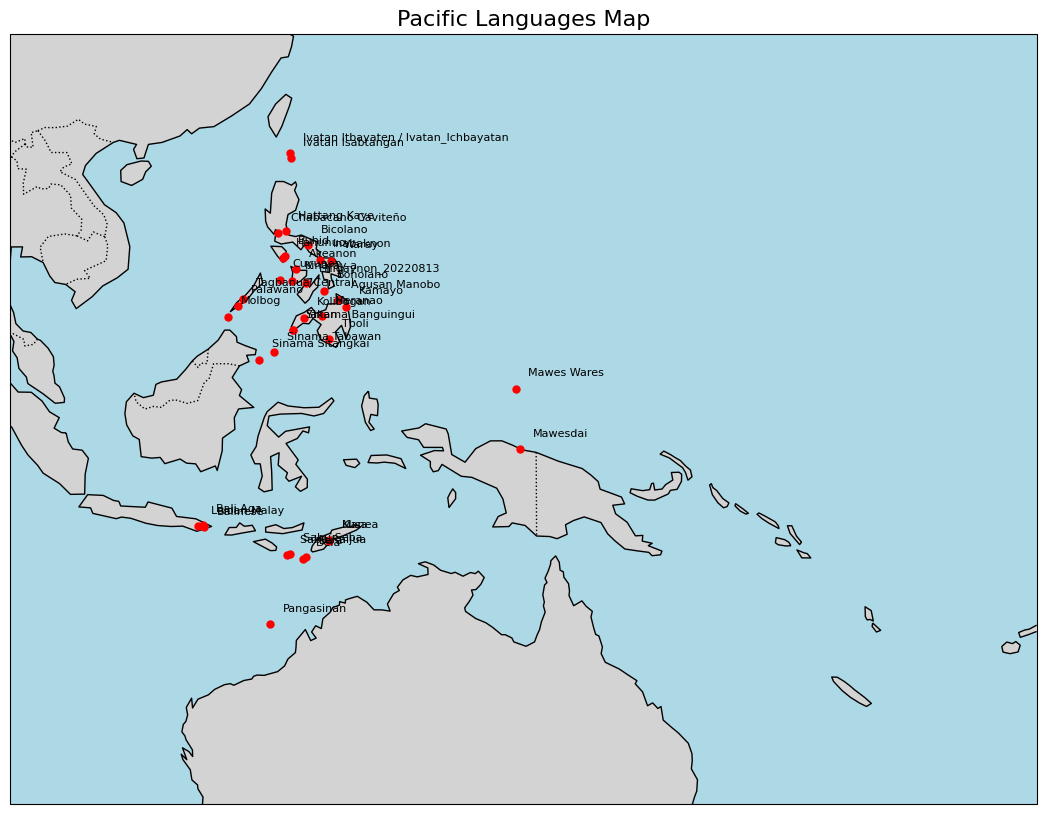

In [44]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Assuming polynesia_geo has columns: 'Language', 'Latitude', 'Longitude'

fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Set map extent to roughly cover the Pacific region
#ax.set_extent([100, -100, 100, 30], crs=ccrs.PlateCarree())
ax.set_extent([100, 180, -30, 30], crs=ccrs.PlateCarree())

# Add map features for context
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot each language point and label it
for idx, row in languages_gdf.iterrows():
    ax.plot(row['Longitude'], row['Latitude'], 'o', color='red', markersize=5, transform=ccrs.PlateCarree())
    ax.text(row['Longitude'] + 1, row['Latitude'] + 1, row['Language'], fontsize=8, transform=ccrs.PlateCarree())

plt.title("Pacific Languages Map", fontsize=16)
plt.show()